## Harvard CS109b
### Tutorial (1)
### Pan-STARRS SMF Data Format
### Matthew J. Holman, Matthew J. Payne
#### 22 April 2019



In [1]:
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
import random
import itertools
from collections import defaultdict
import importlib
from astropy.io import fits

import ps1_astrom
import ps1_utils

from scipy.optimize import curve_fit
import scipy as sp

import ephem
import healpy as hp

import os
from scipy import spatial
import sqlite3 as lite
import sys
import warnings

from collections import Counter

import socket

import warnings
warnings.filterwarnings('ignore')

# Make the figures bigger
plt.rcParams['figure.figsize'] = [13, 13]

In [2]:
first=lambda x: x[0]
second=lambda x: x[1]

### The Pan-STARRS-1 Data

Rather than searching the Pan-STARRS-1 images themselves, we rely on catalogs of detections extracted from those images by the Image Processing Pipeline (IPP) [reference needed].  The image data comprises petabytes.  Fortunately, the catalogs extracted from those images comprise terabytes.

We have access to 1.3 million smf files. And more are being generated all the time (now on PS1 and PS2).

The Pan-STARRS catalog data from each exposure is stored in a multi-extension FITS files called an 'smf file', so named from its suffix.  I have no idea what 'smf' stands for or if 'file' is redundant, as in 'S M File file'.

There are 182 extensions in a standard smf.  These are:

+ PRIMARY for the overall exposure.  This includes the filter, the time and duration of the exposure, WCS information, and much, much more.  There is only header information for PRIMARY

+ MATCHED_REFS contains information about the referencd stars that were used to determine the astrometric solution and photometric zero point for the overall exposure as well as for each detector.  MATCHED_REFS has both header information and data.  The data is a binary table of the stars used.  It's incredibly useful!

+ For each of the 60 detectors/chips there is an '.hdr' extension, a '.psf' extension, and a '.deteff' extension. 

    - The '.hdr' extension contains header information for that detector.   This includes WCS information, and much much more.

    - The '.psf' extension is a binary table with each row representing a detection returned by the IPP.

    - The '.deteff' extension contains detection efficiency results based on synthetic sources inserted into the detector by the IPP.



Let's explore the structure and content of an smf file.  The fits package in astropy.io makes this very easy.

We can open any FITS file as below.  We get back an collection of HDU (Header-Data Units).

It takes about a second to open an smf file.  We can iterate over the HDUs in various pythonic ways.  (Refer to the astropy documentation for more details.)

We will use the FITS library in astropy for much of this work: 

http://docs.astropy.org/en/stable/io/fits/index.html

In [3]:
from astropy.io import fits

Here we use the fits library to open an example smf file named 'o6771g0234o.729155.cm.943415.smf'

In [4]:
%%time
smf = '/Users/user/Downloads/o4998g0341o.78361.cm.1163823.smf'

hdus = fits.open(smf)

CPU times: user 4.21 ms, sys: 1.44 ms, total: 5.65 ms
Wall time: 34.1 ms


Here we will show how to plot the detections for a particular 'chip' within the smf file (we discuss the structure of the detections & the smf files in greater detail below) 

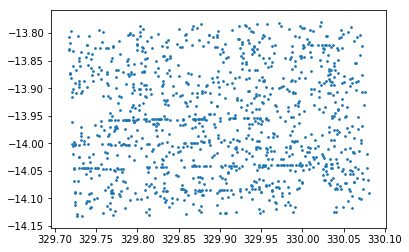

In [5]:
_=plt.scatter(hdus['XY13.psf'].data['RA_PSF'], hdus['XY13.psf'].data['DEC_PSF'], s=3)


 It's handy to have a list of the names of the chips.  They are organized into an x-y grid, with the corners missing.

In [6]:
chips=['XY01', 'XY02', 'XY03', 'XY04', 'XY05', 'XY06',
       'XY10', 'XY11', 'XY12', 'XY13', 'XY14', 'XY15', 'XY16', 'XY17',
       'XY20', 'XY21', 'XY22', 'XY23', 'XY24', 'XY25', 'XY26', 'XY27',
       'XY30', 'XY31', 'XY32', 'XY33', 'XY34', 'XY35', 'XY36', 'XY37',
       'XY40', 'XY41', 'XY42', 'XY43', 'XY44', 'XY45', 'XY46', 'XY47',
       'XY50', 'XY51', 'XY52', 'XY53', 'XY54', 'XY55', 'XY56', 'XY57',
       'XY60', 'XY61', 'XY62', 'XY63', 'XY64', 'XY65', 'XY66', 'XY67',
       'XY71', 'XY72', 'XY73', 'XY74', 'XY75', 'XY76']

We can now plot the data from all of the detectors.  
The detectors are the large squares of detections in the plot below, with each detector having a coherent color.
There are gaps between the large square detectors.  
Each detector is composed of an 8x8 grid of 'cells.'  
There is an insensitve region separating each cell from its neighbors.  In addition, some cells are 'dead.'  There are no detections reported by dead cells.

There appears to be an excess points along the edges of the cells.  
This shows up as a 'waffle pattern' in the image below.  These excess points are very likely to be false detections.

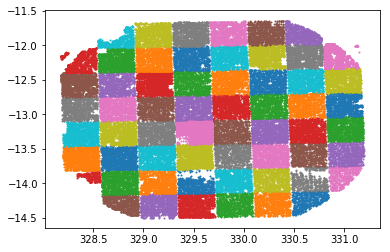

In [7]:
for chip in chips:
    extension_name = chip+'.psf'
    hdu = hdus[extension_name]
    _=plt.scatter(hdu.data['RA_PSF'], hdu.data['DEC_PSF'], s=1)
    


We see all 182 extension names. 

In [13]:
hdu_names = [hdu.name for hdu in hdus]
hdu_names

['PRIMARY',
 'MATCHED_REFS',
 'XY01.hdr',
 'XY01.psf',
 'XY01.deteff',
 'XY02.hdr',
 'XY02.psf',
 'XY02.deteff',
 'XY03.hdr',
 'XY03.psf',
 'XY03.deteff',
 'XY04.hdr',
 'XY04.psf',
 'XY04.deteff',
 'XY05.hdr',
 'XY05.psf',
 'XY05.deteff',
 'XY06.hdr',
 'XY06.psf',
 'XY06.deteff',
 'XY10.hdr',
 'XY10.psf',
 'XY10.deteff',
 'XY11.hdr',
 'XY11.psf',
 'XY11.deteff',
 'XY12.hdr',
 'XY12.psf',
 'XY12.deteff',
 'XY13.hdr',
 'XY13.psf',
 'XY13.deteff',
 'XY14.hdr',
 'XY14.psf',
 'XY14.deteff',
 'XY15.hdr',
 'XY15.psf',
 'XY15.deteff',
 'XY16.hdr',
 'XY16.psf',
 'XY16.deteff',
 'XY17.hdr',
 'XY17.psf',
 'XY17.deteff',
 'XY20.hdr',
 'XY20.psf',
 'XY20.deteff',
 'XY21.hdr',
 'XY21.psf',
 'XY21.deteff',
 'XY22.hdr',
 'XY22.psf',
 'XY22.deteff',
 'XY23.hdr',
 'XY23.psf',
 'XY23.deteff',
 'XY24.hdr',
 'XY24.psf',
 'XY24.deteff',
 'XY25.hdr',
 'XY25.psf',
 'XY25.deteff',
 'XY26.hdr',
 'XY26.psf',
 'XY26.deteff',
 'XY27.hdr',
 'XY27.psf',
 'XY27.deteff',
 'XY30.hdr',
 'XY30.psf',
 'XY30.deteff',
 'XY3

 The PRIMARY contains a wealth of information about the overall mosaic of detectors, such as when the exposure was taken, what filter was used, where the telescope was pointing, and how long the exposure was.

In [14]:
hdus['PRIMARY'].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / this file has extensions                       
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CONTROLR= 'STARGRASP'                                                           
PSFORMAT= 'MEF     '                                                            
PSMOSAIC= 'CHIP    '           / Mosaicked level                                
M2Z     =              -811.75 / Telescope focus                                
FILTERID= 'y.00000 '           / Filter used (instrument name)                  
POSANGLE=             268.9397 / Position angle of instrument                   
ROT     =            -109.75

Each detector also has a header of information that is specific to it.

In [15]:
hdus['XY13.hdr'].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTEND  =                    T / File contains extensions                       
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
NEXTEND =                   65 / Number of extensions                           
QUEUEID = 'ThreePi y E-2a'                                                      
TESSEL  =                -9999                                                  
FILENAME= 'o4998g0341o13'      / Base filename at acquisition                   
DATE    = '2009-06-16T13:52:

Each image from each detector from each exposure gets a unique, sequential ID number.  This is very useful for creating unique IDs, if needed.

In [16]:
[(hdu.name, hdu.header['IMAGEID']) for hdu in hdus if '.hdr' in hdu.name][0:10]

[('XY01.hdr', 71509968),
 ('XY02.hdr', 71509969),
 ('XY03.hdr', 71509970),
 ('XY04.hdr', 71509971),
 ('XY05.hdr', 71509972),
 ('XY06.hdr', 71509973),
 ('XY10.hdr', 71509974),
 ('XY11.hdr', 71509975),
 ('XY12.hdr', 71509976),
 ('XY13.hdr', 71509977)]

The sources detected by each individual chip are stored in the '.psf' extensions, one row for each.  There are many, many columns (i.e. 'features') for each detection.  Of interest are the local chip coordinates ('X_PSF', 'Y_PSF'), the magnitude or brightness of the source ('CAL_PSF_MAG'), a bit mask of flags ('FLAGS'), and the moments or shape parameters.

We will describe the 'FLAGS' field in detail later.

In [17]:
hdus['XY13.psf'].columns

ColDefs(
    name = 'IPP_IDET'; format = '1J'; bscale = 1; bzero = 2147483648
    name = 'X_PSF'; format = '1E'
    name = 'Y_PSF'; format = '1E'
    name = 'X_PSF_SIG'; format = '1E'
    name = 'Y_PSF_SIG'; format = '1E'
    name = 'POSANGLE'; format = '1E'
    name = 'PLTSCALE'; format = '1E'
    name = 'PSF_INST_MAG'; format = '1E'
    name = 'PSF_INST_MAG_SIG'; format = '1E'
    name = 'PSF_INST_FLUX'; format = '1E'
    name = 'PSF_INST_FLUX_SIG'; format = '1E'
    name = 'AP_MAG'; format = '1E'
    name = 'AP_MAG_RAW'; format = '1E'
    name = 'AP_MAG_RADIUS'; format = '1E'
    name = 'AP_FLUX'; format = '1E'
    name = 'AP_FLUX_SIG'; format = '1E'
    name = 'AP_NPIX'; format = '1J'
    name = 'CAL_PSF_MAG'; format = '1E'
    name = 'CAL_PSF_MAG_SIG'; format = '1E'
    name = 'RA_PSF'; format = '1D'
    name = 'DEC_PSF'; format = '1D'
    name = 'PEAK_FLUX_AS_MAG'; format = '1E'
    name = 'SKY'; format = '1E'
    name = 'SKY_SIGMA'; format = '1E'
    name = 'PSF_CHISQ'; format =

Here is a single row corresponding to a single detection.  
Each data element corresponds to the columns above.

In [18]:
det_num = 500 
hdus['XY13.psf'].data[det_num]

(500, 2409.6333, 2027.503, 0.4745726, 0.4745726, -88.709366, -0.25648147, -7.7179174, 0.2230491, 1222.2692, 272.62607, -6.5633984, -6.484393, 12.0, 422.04547, 21.304956, 203, 19.327927, 0.10875034, 329.8688985611731, -13.955376377686896, -4.515379, 376.41006, 19.137753, 1348.5941, nan, -1.3702701, 2.0919175, 1.8104315, 36.366173, -0.013563223, 5.938285, 5.139236, 0.5465227, 0.5465227, 1191, 1192, 1.4141484, -0.7803942, 5.323315, -0.21019584, 0.44484308, 0.022564128, 0.24481875, nan, 1.3776337, nan, nan, nan, nan, nan, nan, nan, 35651585, 0, 0, 0)

We can grab all the data in a column like so.  These are numpy arrays that can be manipulated as such.

In [19]:
hdus['XY13.psf'].data['RA_PSF'], hdus['XY13.psf'].data['DEC_PSF']

(array([329.95165405, 329.86244894, 329.79235298, ..., 329.88002033,
        329.93247643, 329.83644905]),
 array([-14.06665093, -13.9508275 , -13.87379623, ..., -13.82299374,
        -13.95375112, -13.92983133]))

We now repeat the  plot made above of the detections on a given chip

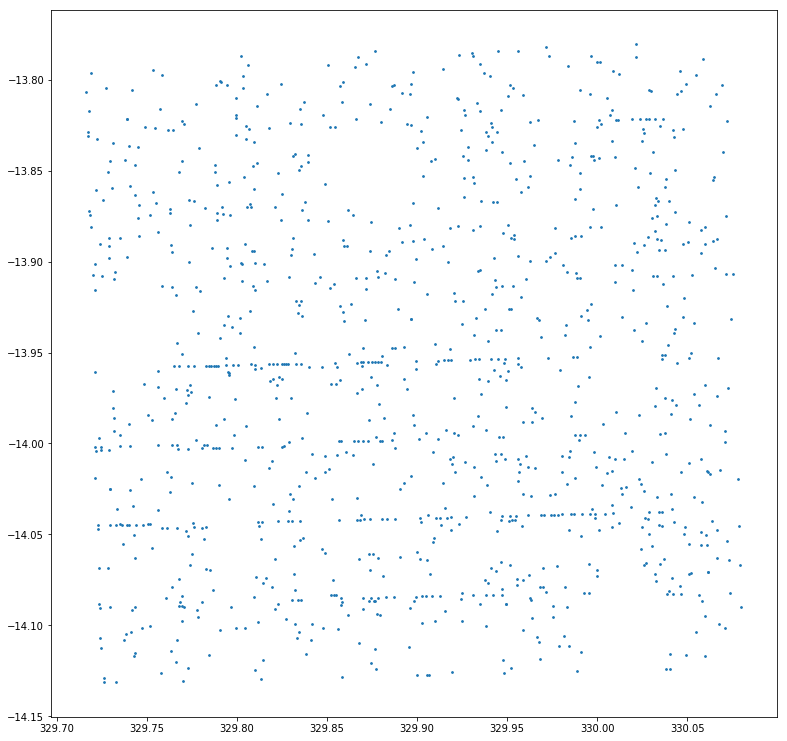

In [21]:
plt.scatter(hdus['XY13.psf'].data['RA_PSF'], hdus['XY13.psf'].data['DEC_PSF'], s=3)


### Matched Reference Stars

The IPP provides a table of all the reference stars used for fitting the astrometric and photometric solution for the exposure.  Again, this is incredibly useful!

In [22]:
mrefs = hdus['MATCHED_REFS']

zpt_obs = hdus['XY01.hdr'].header['ZPT_OBS']
exptime = hdus['XY01.hdr'].header['EXPTIME']

mag_obs = mrefs.data['MAG_INST'] + zpt_obs + 2.5*np.log10(exptime)
mag_ref = mrefs.data['MAG_REF']

In [23]:
mrefs.columns

ColDefs(
    name = 'RA_REF'; format = '1D'
    name = 'DEC_REF'; format = '1D'
    name = 'X_CHIP_REF'; format = '1E'
    name = 'Y_CHIP_REF'; format = '1E'
    name = 'X_CHIP_RAW'; format = '1E'
    name = 'Y_CHIP_RAW'; format = '1E'
    name = 'X_FPA_RAW'; format = '1E'
    name = 'Y_FPA_RAW'; format = '1E'
    name = 'X_TPA_RAW'; format = '1E'
    name = 'Y_TPA_RAW'; format = '1E'
    name = 'MAG_INST'; format = '1E'
    name = 'MAG_REF'; format = '1E'
    name = 'COLOR_REF'; format = '1E'
    name = 'CHIP_ID'; format = '4A'
)

In [24]:
mean_diff = (mag_obs-mag_ref).mean()

In [25]:
mrefs.columns

ColDefs(
    name = 'RA_REF'; format = '1D'
    name = 'DEC_REF'; format = '1D'
    name = 'X_CHIP_REF'; format = '1E'
    name = 'Y_CHIP_REF'; format = '1E'
    name = 'X_CHIP_RAW'; format = '1E'
    name = 'Y_CHIP_RAW'; format = '1E'
    name = 'X_FPA_RAW'; format = '1E'
    name = 'Y_FPA_RAW'; format = '1E'
    name = 'X_TPA_RAW'; format = '1E'
    name = 'Y_TPA_RAW'; format = '1E'
    name = 'MAG_INST'; format = '1E'
    name = 'MAG_REF'; format = '1E'
    name = 'COLOR_REF'; format = '1E'
    name = 'CHIP_ID'; format = '4A'
)

In [26]:
mrefs.data['MAG_REF']

array([12.27643 , 12.321087, 12.359806, ..., 19.388   , 19.389643,
       19.587559], dtype=float32)

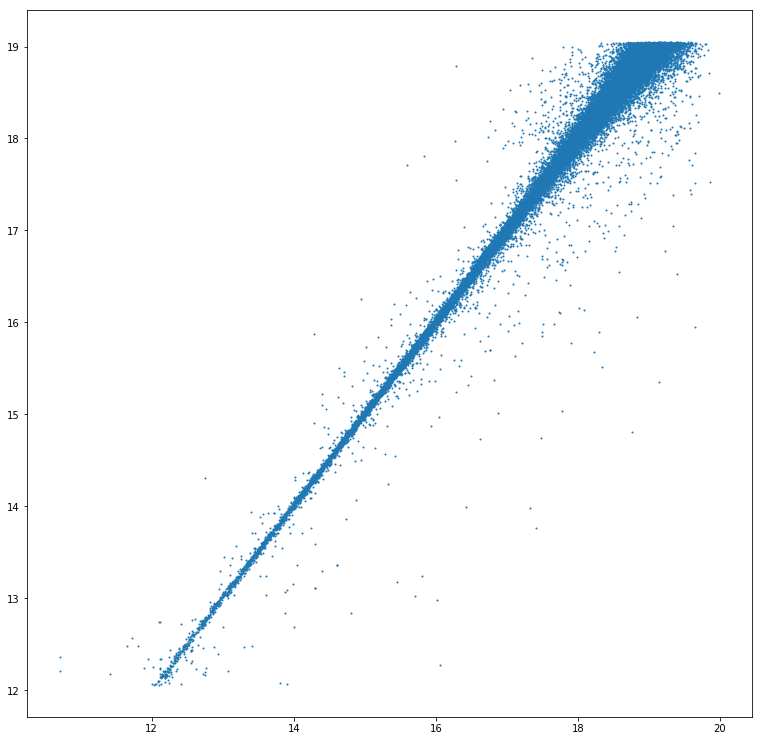

In [27]:
plt.scatter(mag_ref, mag_obs, s=1)

(-0.2, 0.2)

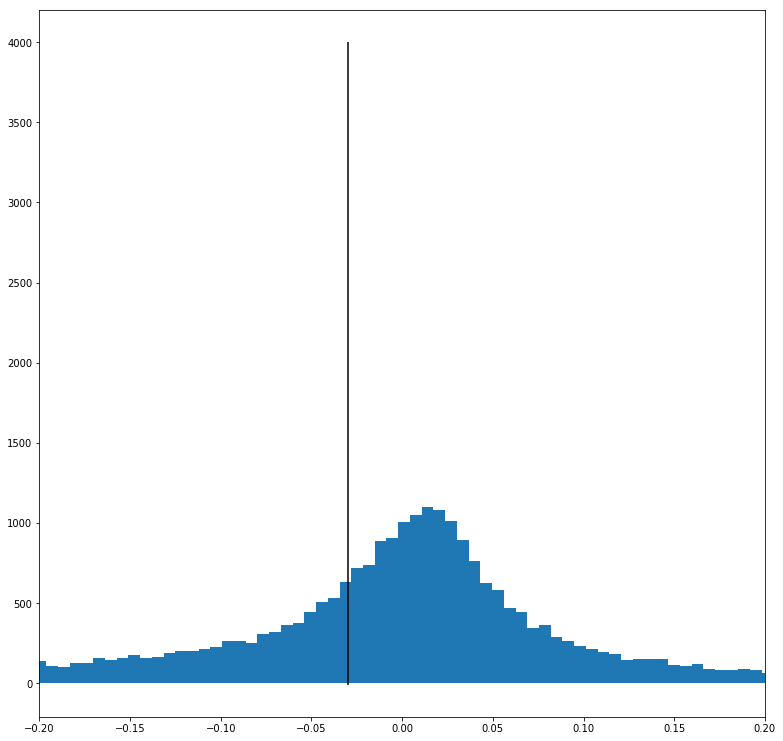

In [28]:
blah= plt.hist(mag_obs-mag_ref, bins=1000)
plt.vlines(mean_diff, -10, 4000)
plt.xlim(-0.2, 0.2)

DETEFF.MAGREF refers to an instrumental magnitude.  To use that, we take the simulated apparent magnitude, subtract the zero point and 2.5*log(exptime) to get an instrumental magnitude.

We then compare the instrumental magnitude to the detection efficiency curve.  


The astrometry in 'MATCHED_REFS' is also very good.  Here are histograms of the residuals of the fitted x, y pixel positions.

In [29]:
mrefs.columns

ColDefs(
    name = 'RA_REF'; format = '1D'
    name = 'DEC_REF'; format = '1D'
    name = 'X_CHIP_REF'; format = '1E'
    name = 'Y_CHIP_REF'; format = '1E'
    name = 'X_CHIP_RAW'; format = '1E'
    name = 'Y_CHIP_RAW'; format = '1E'
    name = 'X_FPA_RAW'; format = '1E'
    name = 'Y_FPA_RAW'; format = '1E'
    name = 'X_TPA_RAW'; format = '1E'
    name = 'Y_TPA_RAW'; format = '1E'
    name = 'MAG_INST'; format = '1E'
    name = 'MAG_REF'; format = '1E'
    name = 'COLOR_REF'; format = '1E'
    name = 'CHIP_ID'; format = '4A'
)

In [33]:
mrefs.data['X_CHIP_REF']

array([3850.1304 , 2237.9812 , 3288.9443 , ...,  346.5868 ,  779.4051 ,
          5.47005], dtype=float32)

In [34]:
mrefs.data['X_CHIP_RAW']

array([3850.1667   , 2238.1064   , 3288.9854   , ...,  345.2613   ,
        779.0357   ,    4.5111055], dtype=float32)

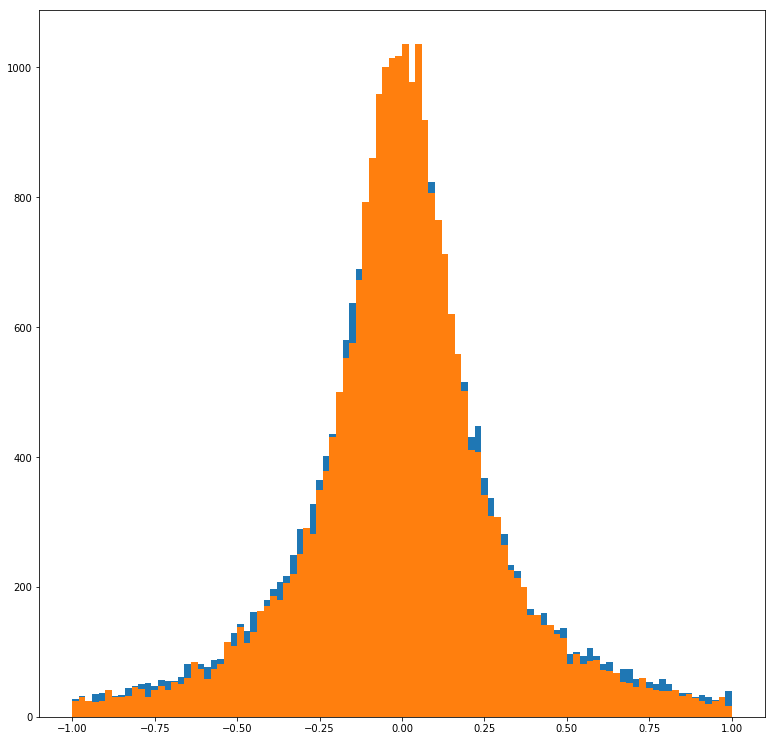

In [35]:
blah = plt.hist(mrefs.data['X_CHIP_REF']-mrefs.data['X_CHIP_RAW'], range=(-1, 1), bins=100)
blah = plt.hist(mrefs.data['Y_CHIP_REF']-mrefs.data['Y_CHIP_RAW'], range=(-1, 1), bins=100)
#plt.xlim(-1, 1)

### False Detections and Bayesian Stuff

The number of detections from a particular chip, or even cell, should be a function of the number of live pixels in it.  Dead pixels don't report photons.  Amazingly, there might be 10^12 detections so far in the Pan-STARRS survey.  That estimate comes the product of 1.3x10^6 exposures and 1.5x10^5 detections/exposure.  The camera has 1.4x10^9 pixels.  That means that on average each pixel has been at the center of about 700 detections, some real and some false.
}
If we make the assumption that detections that correspond to sources in the stationary catalog are real and that all other detections are false, which is not a bad assumption, we can estimate a prior probability that a detection is real or false.

$$  P(A|B) = \frac{P(B|A) P(A)}{P(B)}  $$



Some pixels will contribute much more than the average number of detections.  But the number and distribution of real sources, other than moving solar system objects, is not changing.  Those locations are essentially fixed.    So we can keep track of which detector, cell, and pixel locattion each detection is centered on.  

Our real-bogus classifier will use all the information in the smf, both from the chip and row in which the detection is reported and the other information in the smf, as well as the prior information that comes from the accumulation of many exposures, to estimate the probability that a particular detection is real or bogus.  

The clasifier could use information about sky brightness, time of day, stellar crowding in the region, etc, in its estimates.


- true positive: a detection corresponding to a real source is reported at a given pixel location, and it is classified as real.
- true negative: a detection for which there is no physical source is reported at a given pixel location, and it is classified as false.
- false positive: a detection for which there is no physical source is reported at a given pixel location, and it is classified as real.
- false negative: a detection corresponding to a real source is reported at a given pixel location, and it is classified as false.

We can estimate some of these probabilities because we have an extensive catalog of known sources.  In many cases we will know of a source that is predicted to be seen at a given pixel location.  We will have a prior estimate of its magnitude in various filters, which we can use to estimate the likelihood of detecting it.  Because there are so many exposures, most astrophysical objects that can be detected by Pan-STARRS will have been detected at some point.  Of course, there are some variable sources that might be only rarely detected and there are moving objects, the focus of this project, but these are a small fraction of the total.  We can use the known stationary and moving sources to estimate the true positive rate and false negative rate.

We also have an abundance of false detections.  Some occur in particular detector regions.  Some are due to sky fluctations or scatter light.  Regardless, if a detection does not correspond to an object in the catalog, most likely it is false.  There are some detector regions with many more false detections.  Detections in those regions are more likely to be false.   We can use this information to estimate the true negative and false positve rates.

A few versions of the IPP software have been used; the version used is noted in the smf headers. The static masks are updated from time to time.  And the telescope, camera, and detectors have gone through various changes.  All of these can affect the detection efficiencies and false positive rates.  Fortunately, there is enough data to track these changes and their effects.

Let's start by exploring the data.

We can extract all the chip-level x,y positions for all the detectors into a couple of lists, for plotting.

In [36]:
# Need to defend against missing extensions.
x, y = [],[]
for chip in chips:
    x += list(hdus[chip+'.psf'].data['X_PSF'])
    y += list(hdus[chip+'.psf'].data['Y_PSF'])


If we <strong> fold </strong> the x,y values on the scales of the separations of cells (and hence "stack" the detections from all cells), we see the edges have an abundance of detections. (A plot is shown below, with horizontal and vertical lines to guide the eye.)  

Most of the excess detections along the edges of the cells must be false; nature isn't playing astrophysical tricks on us.

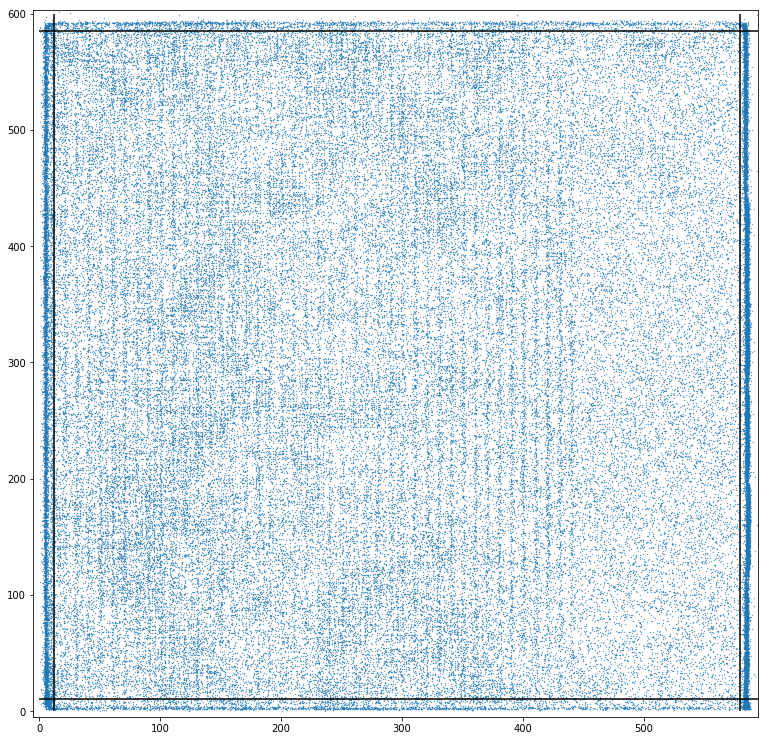

In [37]:
plt.scatter(ps1_utils.foldx(x), ps1_utils.foldy(y), s=0.1)
plt.xlim(-5,595)
plt.ylim(-5,603)
plt.hlines((10, 585), 0,600)
plt.vlines((12, 580), 0,600)

The fraction of pixels on the edge of a cell is a few percent, but the number of false detections there is very high.

In [38]:
(17*590 + 21*598)/(590*598)

0.064021313984468

We can extract various sets of detections to get a sense of how many false detections there are in the edges.
 - Here we are aggressively triming all detections along the edges 

In [39]:
middle_xs = [x for x,y in zip(x, y) if ps1_utils.foldy(y)>10 and ps1_utils.foldy(y)<585]
middle_ys = [y for x,y in zip(x, y) if ps1_utils.foldx(x)>12 and ps1_utils.foldy(x)<580]

middle_xys = [(x,y) for (x,y) in zip(x, y) if ps1_utils.foldx(x)>13 and ps1_utils.foldx(x)<580 and ps1_utils.foldy(y)>6 and ps1_utils.foldy(y)<587]
middle_xys = np.array(middle_xys)

The fraction of the detections that are in the center region is about 86%.  I'll try to estimate the false detection rate in the edge region and in the center in a bit.  We can assume that the rate of real detections is intrinsically similar.  Or rather, the number of real objects that are sending photons in the regions is the same per pixel.

In [40]:
len(middle_xys)/len(x)

0.7537457337111507

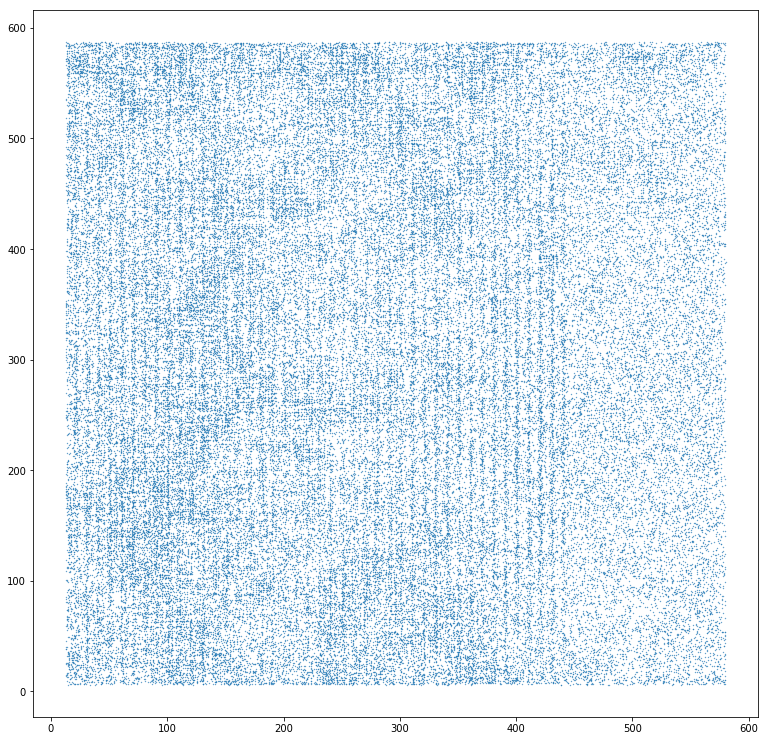

In [41]:
plt.scatter(ps1_utils.foldx(middle_xys[:,0]), ps1_utils.foldy(middle_xys[:,1]), s=0.1)

#### In the cells below we make one-dimensional (x & then y) plots of the number of detections to give approximate justification for the choice of edge-trimming width used above

(-10, 3000)

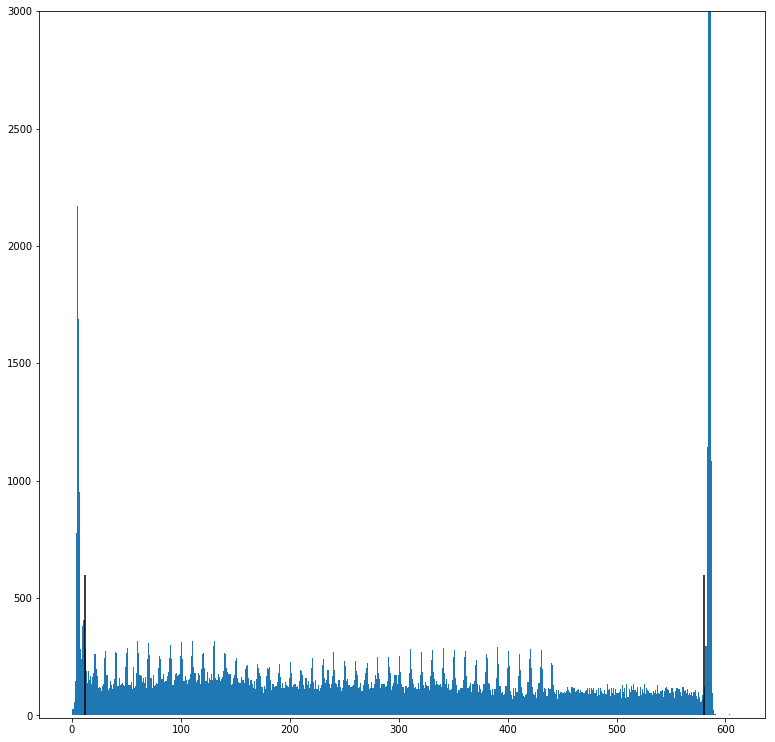

In [42]:
foo = plt.hist(ps1_utils.foldx(middle_xs), bins=600)
plt.vlines((12, 580), 0,600)
plt.ylim(-10,3000)

(-10, 5000)

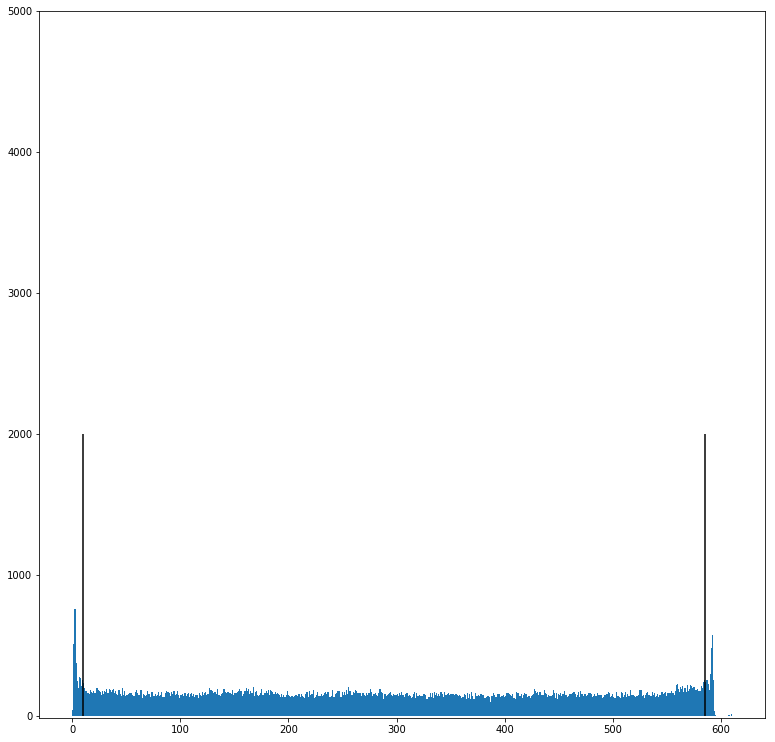

In [43]:
foo = plt.hist(ps1_utils.foldy(middle_ys), bins=600)
plt.vlines((10, 585), 0,2000)
plt.ylim(-10,5000)